---
# Model S - Data Augmentation and L2 Regularization with RMSprop Optimizer
- **32 x 32 x 3** Image size.
- **64** Batch size.
- Root Mean Squared **(RMSprop)** optimizer.
- **0.001** Initial Learning rate.
- **Sparse Categorical Cross-Entropy** loss function.
- **Reduce Learning Rate on Plateau** callback.
- **Early Stopping** callback.
- **Model Checkpoint** callback.
- **Data Augmentation**
    - Random **Horizontal** Flip
    - Random Rotation **10%**
    - Random Zoom **10%**
    - Random Contrast **10%**
    - Random Brightness **10%**
- 4 **Convolutional** layers with **64**, **128**, **256** and **512** filters, with **ReLU** activation.
- 4 **BatchNormalization** layers.
- 2 **MaxPooling** layers with **2 x 2** pool size.
- **3 x 3** Convolutional kernel size.
- **5 x 5 x 256** Tensor before flatten.
- **512** Dense layer with **ReLU** activation.
- **10** Dense output layer with **Softmax** activation.
- **L2** with **0.0001** Regularization on Convolutional and Dense Layers
- **0.5** Dropout rate on Dense layers.
- **3 672 778** Trainable Parameters
- **30** Epochs.

---
#### Imports and Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, optimizers, models
from keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

TensorFlow version: 2.15.0


---
#### Group Datasets

In [2]:
train_dirs = ['../data/train1', '../data/train3', '../data/train4', '../data/train5']
validation_dir = '../data/train2'
test_dir = '../data/test'

---
#### Create Datasets

In [3]:
IMG_SIZE = 32
BATCH_SIZE = 64
NUM_CLASSES = 10

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
data batch shape: (64, 32, 32, 3)
labels batch shape: (64,)


- We define the image size of 32 x 32 x 3, batch size of 64 and create an array with the label's names.  
- We create the train dataset by concatenating them, we **shuffle** the samples before each epoch and **prefetch** them to memory.  
- We do the same for the validation and test dataset except **shuffling** which is **unwanted** for these datasets.

---
#### Data Augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        # keras.layers.RandomCrop(height=16, width=16), # This layer is commented out because it is not compatible with the current model architecture.
        keras.layers.RandomFlip("horizontal"),
        # keras.layers.RandomTranslation(0.1, 0.1), # This layer is commented out because it didn't improve the model performance.
        # keras.layers.RandomRotation(0.1),
        # keras.layers.RandomZoom(0.1),
        # keras.layers.RandomContrast(0.1),
        # keras.layers.RandomBrightness(0.1),
    ]
)

- **We define a data augmentation pipeline to apply to the images**.
- **The pipeline:**
    - Applies horizontal flipping to a random 50% of the images that go through it.
    - Randomly adjusts the contrast of the input images by 10%.
    - Randomly adjusts the brightness of the input images by 10%.
    - Randomly rotates the input images by 10%.
    - Randomly zooms the input images by 10%.

- **The following techniques were tested but the model didn't perform well:**
    - RandomCrop: Randomly crops the images along the width and height down to 16 x 16.
    - Randomly translates the input images along the width and height by 10%.
- **We also didn't find any custom augmentation techniques that improved the model performance**.

---
#### Model Architecture

In [5]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                             

---
#### Model Compilation

In [6]:
initial_learning_rate = 0.0001
optimizer = optimizers.RMSprop(learning_rate=initial_learning_rate)
loss_function = keras.losses.SparseCategoricalCrossentropy()

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
save_best_model = callbacks.ModelCheckpoint(filepath='../models/03_model_s_data_augm_l2_rmsprop.keras', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [lr_scheduler, early_stopping, save_best_model]

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

---
#### Model Training

In [7]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
628/628 [==============================] - ETA: 0s - loss: 1.9860 - accuracy: 0.3543
Epoch 1: val_loss improved from inf to 1.50868, saving model to ../models/03_model_s_data_augm_l2_rmsprop.keras
628/628 [==============================] - 144s 228ms/step - loss: 1.9860 - accuracy: 0.3543 - val_loss: 1.5087 - val_accuracy: 0.4671 - lr: 1.0000e-04
Epoch 2/30
628/628 [==============================] - ETA: 0s - loss: 1.4020 - accuracy: 0.4986
Epoch 2: val_loss improved from 1.50868 to 1.18775, saving model to ../models/03_model_s_data_augm_l2_rmsprop.keras
628/628 [==============================] - 141s 224ms/step - loss: 1.4020 - accuracy: 0.4986 - val_loss: 1.1877 - val_accuracy: 0.5772 - lr: 1.0000e-04
Epoch 3/30
628/628 [==============================] - ETA: 0s - loss: 1.1920 - accuracy: 0.5804
Epoch 3: val_loss improved from 1.18775 to 1.01191, saving model to ../models/03_model_s_data_augm_l2_rmsprop.keras
628/628 [==============================] - 141s 224ms/step - los

---
#### Save Model History

In [8]:
with open("../history/03_model_s_data_augm_l2_rmsprop.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Model Evaluation

In [9]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f'Model Validation Loss: {val_loss:.2f}')
print(f'Model Validation Accuracy: {val_acc:.2%}')

157/157 [==============================] - 8s 48ms/step - loss: 0.5222 - accuracy: 0.8304
Model Validation Loss: 0.52
Model Validation Accuracy: 83.04%


---
#### Model Training Visualization

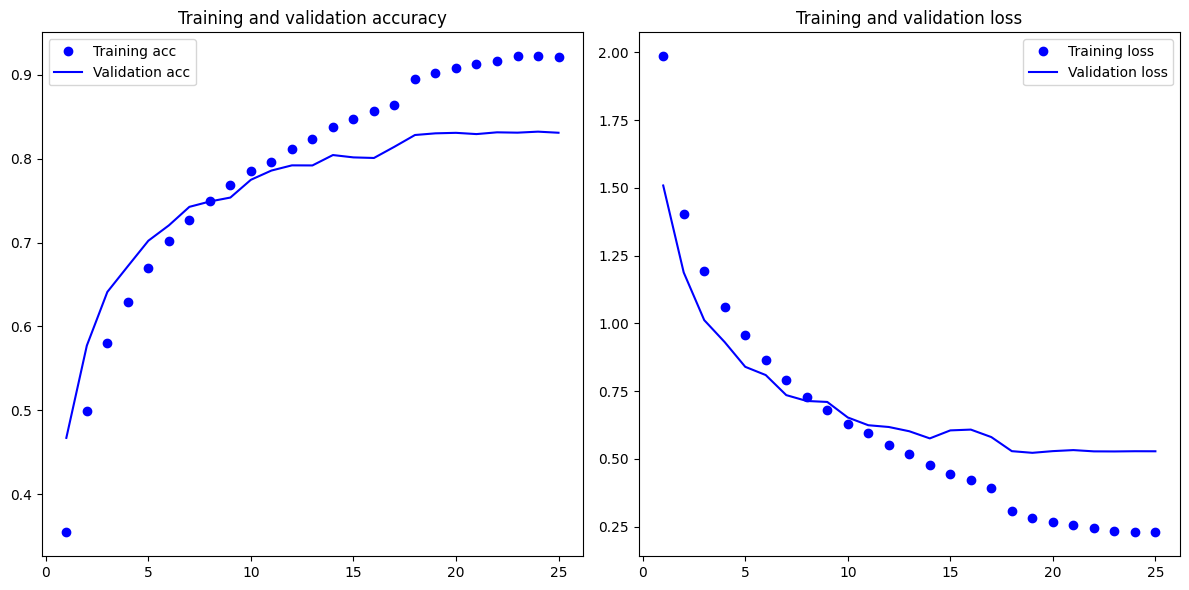

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

- Analyzing the training and validation, accuracy and loss over the epochs:
    - We see that the model begins overfitting after the **4th** epoch.
    - The training accuracy stops improving significantly after the **11th** epoch while the training accuracy keeps improving.
    - The validation loss stops improving significantly after the **11th** epoch while the training loss keeps improving.
    - The best model, based on validation loss, is saved on the **16th** epoch.
    - The training stops after the **20th** epoch because of the **Early Stopping** callback.

---
#### Model Testing

In [11]:
test_labels = []
test_predictions = []
test_probabilities = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))
    test_probabilities.extend(predictions)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

1/1 [==============================] - 0s 96ms/step


---
#### Confusion Matrix

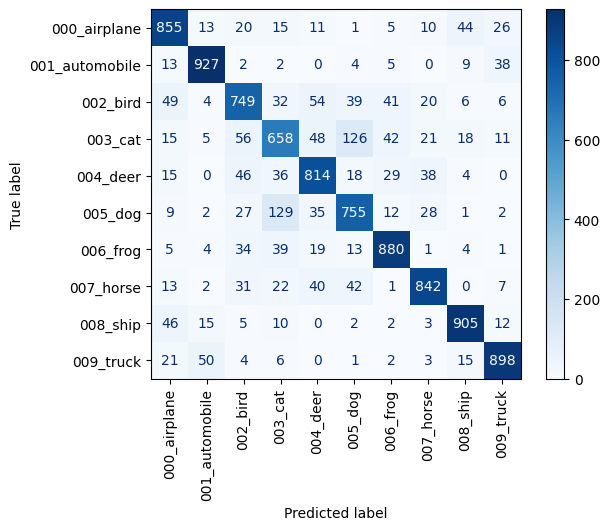

In [12]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

- Looking at the confusion matrix, we see that:  
    - The model has a hard time distinguishing the categories 003_cat and 005_dog.  
    - The model has a below average performance on the categories 003_cat, 005_dog, 002_bird and 004_deer, in which we see a very high false positive rate.
    - The model also has a hard time distinguishing between some other categories but the error is not as significant.  
    - The model has an above average performance on the categories 001_automobile, 006_frog, 008_ship and 009_truck.
    - Basically, the model has the same performance but with higher accuracy.

---
#### ROC Curve Analysis

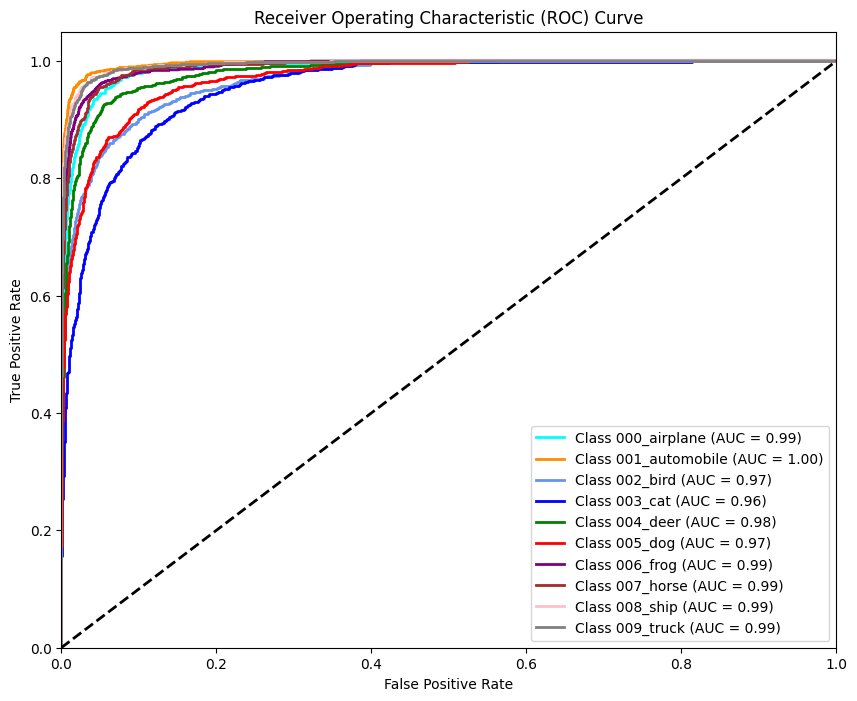

In [13]:
test_labels_bin = label_binarize(test_labels, classes=range(NUM_CLASSES))

false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'grey'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the ROC curve:
    - We see that the model has a mediocre performance on the ROC curve for most categories.  
    - The categories 003_cat, 002_bird, 005_dog and 004_deer have the worst AUC (Area Under Curve) performance.
    - The other categories have the same performance but with higher AUC.
    - The category 001_automobile has the best AUC performance.
    - The overall AUC performance increases as the false positive rate decreases and the true positive rate increases.
    - **A perfect AUC of 1.0 would mean that the model classifies all images either true positives or true negatives**.

---
#### Performance Metrics
- **Accuracy** is the proportion of correctly predicted instances out of the total instances.  
- **Precision** is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
- **Weighted precision** calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
- **Recall** is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
- **Weighted recall** calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
- The **F1-score** is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
- **Weighted F1-score** calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.

In [14]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 82.83%
Precision - Macro: 82.74%
Recall - Macro: 82.83%
F1-score - Macro: 82.77%
Precision - Weighted: 82.74%
Recall - Weighted: 82.83%
F1-score - Weighted: 82.77%


- **Since the dataset is balanced, the MACRO average is a good metric to evaluate the model.**

# Conclusion
### Summary
- In this notebook:
    - We enhanced the architecture by:
        - We used L2 regularization.
    - We applied data augmentation techniques:
        - Random horizontal flip
        - Random Zoom
        - Random Brightness
        - Random Contrast
    - We used the Root Mean Squared Propagation (RMSProp) optimizer.
    - We kept the same 30 epochs.
    - Overfitting was observed after **12 epochs**, but the best model was saved at the **20th epoch**.
    - Training was intended for 30 epochs but stopped early due to the **Early Stopping** callback.
    - We evaluated the model using a confusion matrix to analyze its performance on each category.
    - We evaluated the model using ROC curves for a deeper performance analysis.
    - The model achieved an accuracy of **70.87%** on the test set.
    - The model showed some difficulty distinguishing between certain categories, particularly cats and dogs.
    - The model showed a below average performance on the categories birds and deer.
    - The model showed an above average performance on the categories automobile, frog, ship and truck.

### Future Work
- In the next notebook:
    - We will upscale the dataset images to 160 x 160.
    - We will use feature extraction with the VGG16 Convolutional Base to:
        - Extract the train dataset feature maps.
        - Extract the validation dataset feature maps.
    - We will then train a classifier model with those extracted feature maps.
    - We will keep the same 30 epochs.